# Attack and anomaly detection in IoT sensors in IoT sites using machine learning approaches

Article information:
* Authors: Mahmudul Hasan, Milon Islam, Ishrak Islam Zarif and M.M.A.Hashem
* Publication: 20 May 2019
* DOI: https://doi.org/10.1016/j.iot.2019.100059

## Objective

In this notebook we test under sampling of the majority class to balanced the dataset.

In [1]:
# import numpy and pandas to load the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# graphics
from pylab import rcParams
%matplotlib inline 
rcParams['figure.figsize'] = 8, 8

# load dataset
df = pd.read_csv('https://media.githubusercontent.com/media/mariolpantunes/ml101/main/datasets/mainSimulationAccessTraces.csv',  error_bad_lines=False, header = 0)

## Data preprocessing

In [2]:
# Fix missing Accessed Node Type
df = df.fillna({'accessedNodeType': 'Malicious'})

# Fix the malformated values in column Value
df = df.fillna({'value': 0.0})
replace_values = {'true': 1.0, 'false': 0.0, 'twenty': 20.0, 'none': 0.0}
df = df.replace({'value':replace_values})

# Fix other errors not mentioned on the paper
df.loc[df.value.str.contains('^org').fillna(False), 'value'] = df[df.value.str.contains('^org').fillna(False)]['value'].apply(lambda x: int(x.split('@')[1],16))

# Replace the names of the target variable to be consistent with the paper
replace_values={'anomalous(DoSattack)':'DoS', 'anomalous(scan)': 'SC', 'anomalous(malitiousControl)':'M.C',
               'anomalous(malitiousOperation)': 'M.O', 'anomalous(spying)':'SP', 'anomalous(dataProbing)':'D.P',
               'anomalous(wrongSetUp)':'W.S', 'normal':'NL'}
df = df.replace({'normality':replace_values})

# Check for NaN values
missing = df.isnull().values.any()
print('Missing Values ? {}'.format(missing))

Missing Values ? False


In [3]:
# Convert timestamp to datetime
time = pd.to_datetime(df['timestamp'], unit='ms')
df['timestamp'] = time

# Sort the samples by the timestamp
df.sort_values('timestamp')

# Drop the non-relevant feature
df = df.drop('timestamp', 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357952 non-null  object
 9   operation                  357952 non-null  object
 10  value                      357952 non-null  object
 11  normality                  357952 non-null  object
dtypes: object(12)
memory usage: 32.8+ MB


### Resample

As stated previously the dataset is quite uneven.
For that reason we will apply a resampling strategy to improve the ratio of the dataset.
We selected random under-sampling that reduces the majority class.

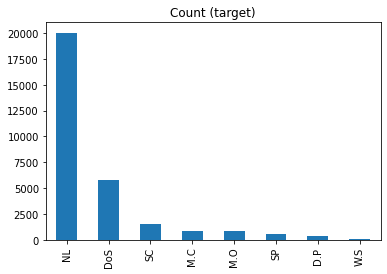

In [4]:
# Separate the dataset into normal and anomaly 
df_normal  = df[df['normality'] == 'NL']
df_anomaly = df[df['normality'] != 'NL']

# Count the total number of anomalies
anomaly_count = df_anomaly.normality.value_counts().sum()

f=2.0

# Random re-sample the normal part to be factor x number of anomalies
df_normal  = df_normal.sample(int(f*anomaly_count))

# Merge the two dataframes
df = pd.concat([df_normal, df_anomaly], axis=0)

df.normality.value_counts().plot(kind='bar', title='Count (target)');

## Encoding categorical values

In [5]:
print('Dataset datatypes (before transformation):')
print(df.dtypes)

# Convert value to float
df['value'] = pd.to_numeric(df['value'])

# Convert target variable to categorical
df['normality'] = df['normality'].astype('category')

# Apply label enconding to the remaining columns
# The label encoding was applied directly with pandas
columns=['sourceID', 'sourceAddress', 'sourceType','sourceLocation',
'destinationServiceAddress', 'destinationServiceType', 'destinationLocation', 
'accessedNodeAddress', 'accessedNodeType', 'operation']

for column in columns:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes

print('------------------------------------------------------')
print('Dataset datatypes (after transformation):')
print(df.dtypes)

Dataset datatypes (before transformation):
sourceID                     object
sourceAddress                object
sourceType                   object
sourceLocation               object
destinationServiceAddress    object
destinationServiceType       object
destinationLocation          object
accessedNodeAddress          object
accessedNodeType             object
operation                    object
value                        object
normality                    object
dtype: object
------------------------------------------------------
Dataset datatypes (after transformation):
sourceID                         int8
sourceAddress                    int8
sourceType                       int8
sourceLocation                   int8
destinationServiceAddress        int8
destinationServiceType           int8
destinationLocation              int8
accessedNodeAddress              int8
accessedNodeType                 int8
operation                        int8
value                         floa

## Dataset convertion

In [6]:
# Import the preprocessing libraries
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Convert pandas dataframe X and y
columns=['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation', 
'destinationServiceAddress', 'destinationServiceType', 'destinationLocation',
'accessedNodeAddress', 'accessedNodeType', 'operation', 'value']
le = preprocessing.LabelEncoder()
le.fit(df.normality)
y = le.transform(df.normality)
X = df[columns].copy()

#Scale only the numerical feature (value)
scaler = StandardScaler()
feature = X[['value']]
scaler.fit(feature.values)
feature = scaler.transform(feature.values)
X.loc[:, 'value'] = feature

## Models

In [7]:
import math

# Helper functions to compute performance metrics
def decompose_cm(cm, c=0):
    TP = cm[c,c]
    tmp = np.delete(np.delete(cm, c, 0), c, 1)
    TN = np.sum(tmp)
    FP = np.sum(cm[c, :]) - TP
    FN = np.sum(cm[:, c]) - TP
    return TP, TN, FP, FN


def compute_performance_metrics(tp, tn, fp, fn):
    mcc = mcc = float(tp*tn - fp*fn) / math.sqrt(float(tp+fp)*float(tp+fn)*float(tn+fp)*float(tn+fn))
    if (tp+tn) == 0.0:
        return 0,0,0,0,mcc
    else:
        acc = (tp+tn)/(tp+tn+fp+fn)
        if tp == 0.0:
            return acc, 0, 0, 0, mcc
        else:
            pre = tp/(tp+fp)
            rec = tp/(tp+fn)
            f1 = (2*tp)/(2*tp + fp + fn)
            
    return acc, pre, rec, f1, mcc

In [8]:
# Library used to speedup computation
from joblib import parallel_backend

# Import the necessary models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Import the stratified KFold library
from sklearn.model_selection import StratifiedKFold

# RoC related libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Prepare the dataset to be used in 5-fold cross validation
skf = StratifiedKFold(n_splits=5)

# List of models names and models algorithms
models = [
    ('LR',  SGDClassifier(loss='log', class_weight='balanced')),
    ('SVM', SGDClassifier(loss='hinge', class_weight='balanced')),
    ('DT',  DecisionTreeClassifier(class_weight='balanced')),
    ('RF',  RandomForestClassifier(class_weight='balanced')),
    ('ANN', MLPClassifier())
]

# Dictionary that will contain the confusion matrix for each model
cm = {}

# Dictionary that will contain the RoC scores
roc = {}

# fold counter
k=0

# FPR for ROC curve
mean_fpr = np.linspace(0, 1, 100)

# Use the parallel backend to speedup the fit operation
with parallel_backend('threading'):
    
    # For each fold
    for train_index, test_index in skf.split(X, y):
        k += 1
        print('K-Fold: {}'.format(k))
    
        #X_train, X_test = X[train_index], X[test_index]
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y[train_index], y[test_index]
        #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    
        # For each model
        for model in models:
            print('\tModel: {}'.format(model[0]))
            model[1].fit(X_train, y_train)
            y_pred = model[1].predict(X_test)
            
            # Store the information for the confusion matrix
            if model[0] in cm:
                cm[model[0]] = np.add(cm[model[0]], confusion_matrix(y_test, y_pred))
            else:
                cm[model[0]] = confusion_matrix(y_test, y_pred)
            
            # Store the information for the RoC curve
            tpr = []
            
            for i in range (0, len(cm[model[0]])):
                f, t, _ = roc_curve(y_test, y_pred, pos_label=i)
                r = auc(f, t)
                interp_tpr = np.interp(mean_fpr, f, t)
                interp_tpr[0] = 0.0
                tpr.append(interp_tpr)
            
            if model[0] in roc:
                roc[model[0]]['tpr'].append(tpr)
            else:
                d = {}
                d['tpr'] = [tpr]
                roc[model[0]] = d

# Compute the mean values for TPR
for model in models:
    d = roc[model[0]]
    d['tpr'] = np.array(d['tpr']).mean(0)

K-Fold: 1
	Model: LR
	Model: SVM
	Model: DT
	Model: RF
	Model: ANN
K-Fold: 2
	Model: LR
	Model: SVM
	Model: DT
	Model: RF
	Model: ANN
K-Fold: 3
	Model: LR
	Model: SVM
	Model: DT
	Model: RF
	Model: ANN
K-Fold: 4
	Model: LR
	Model: SVM
	Model: DT
	Model: RF
	Model: ANN
K-Fold: 5
	Model: LR
	Model: SVM
	Model: DT
	Model: RF
	Model: ANN


## Comparison Table

In [9]:
print('Evaluation  Classifiers')
print('Metrics     LR    SVM   DT    RF    ANN')

accuracy = []
precision = []
recall = []
f1 = []
mcc = []

# For all models
for model in models:
    acc_score = pre_score = rec_score = f1_score = mcc_score = 0
    
    # For all classes
    for i in range(0, len(cm[model[0]])):
        tp, tn, fp, fn = decompose_cm(cm[model[0]], i)
        a, p, r, f, m  = compute_performance_metrics(tp, tn, fp, fn)
        acc_score += a
        pre_score += p
        rec_score += r
        f1_score  += f
        mcc_score += m
    
    # Compute macro average
    acc_score /= len(cm[model[0]])
    pre_score /= len(cm[model[0]])
    rec_score /= len(cm[model[0]])
    f1_score  /= len(cm[model[0]])
    mcc_score /= len(cm[model[0]])
    
    #
    accuracy.append(acc_score)
    precision.append(pre_score)
    recall.append(rec_score)
    f1.append(f1_score)
    mcc.append(mcc_score)

print('Accuracy    {:4.3f} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(*accuracy))
print('Precision   {:4.3f} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(*precision))
print('Recall      {:4.3f} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(*recall))
print('F1 score    {:4.3f} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(*f1))
print('MCC         {:4.3f} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(*mcc))

Evaluation  Classifiers
Metrics     LR    SVM   DT    RF    ANN
Accuracy    0.951 0.946 0.996 0.995 0.996
Precision   0.627 0.650 0.958 0.943 0.958
Recall      0.581 0.562 0.986 0.986 0.982
F1 score    0.582 0.580 0.971 0.963 0.969
MCC         0.554 0.551 0.968 0.959 0.966


## Confusion Matrix

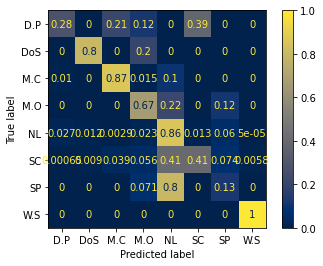

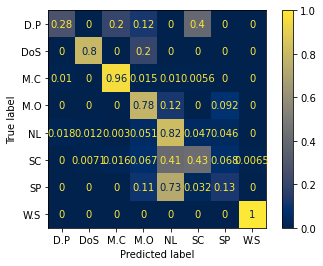

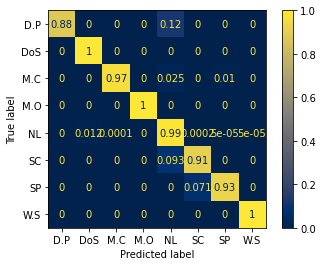

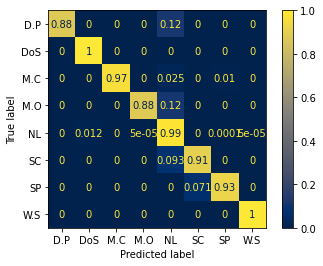

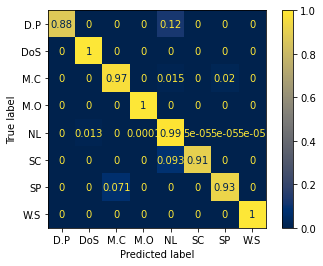

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# For all models
labels = le.inverse_transform(list(range(0, len(cm[model[0]]))))
for model in models:
    # Normalise
    normalized_cm = cm[model[0]].astype('float') / cm[model[0]].sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, display_labels=labels)
    disp.plot(cmap='cividis')

## Conclusion

In this notebook we added a step to balance the dataset.
We implemented a under sampling of the majority class, in this case the normal state. The undersampling was performed as followns:
1. Count the number of anomalies (#NA)
2. Random sample facto * #NA normal labelled samples

Furthermore, we added the following option to all the possible models: `class_weight='balanced'`

We tested 3 different factors ([1.0, 2.0, 3.0]) and added the MCC score as a metric to better evalute the performance between the classifiers.

The best values of MCC were obtained with a factor of 2.